Business need to know whether or not a customer to make a next business. If they think customer may not purchase, business can send promotion to customers. It is very important step to keep customer with business and prevent churn.

One way to do it is predicting the next purchase day of the customer. **What if you know if a customer is likely to make another purchase in 7 days?**  

We can build our strategy on top of that and come up with lots of tactical actions like:   
No promotional offer to this customer since s/he will make a purchase anyways
Nudge the customer with inbound marketing if there is no purchase in the predicted time window (or fire the guy who did the prediction 🦹‍♀️ 🦹‍♂️ )


In [1]:
from __future__ import division

%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime, timedelta,date
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans  

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [3]:
tx_data = pd.read_csv('./Downloads/data/OnlineRetail.csv',encoding= 'unicode_escape')
tx_data.shape

(541909, 8)

In [4]:
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [6]:
tx_data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [7]:
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

We use six months of behavioral data to predict customers’ first purchase date in the next three months. If there is no purchase, we will predict that too. Let’s assume our cut off date is Sep 9th ’11 and split the data

In [8]:
tx_6m = tx_uk[(tx_uk.InvoiceDate < datetime(2011,9,1)) & (tx_uk.InvoiceDate >= datetime(2011,3,1))].reset_index(drop=True)

In [9]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom
1,545220,48194,DOORMAT HEARTS,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom
2,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-03-01 08:30:00,1.65,14620.0,United Kingdom
3,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-03-01 08:30:00,4.95,14620.0,United Kingdom
4,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2011-03-01 08:30:00,3.75,14620.0,United Kingdom


tx_6m represents the six months performance whereas tx_next for the find out the days between the last purchase date in tx_6m and the first one in tx_next.

In [10]:
tx_next = tx_uk[(tx_uk.InvoiceDate >= datetime(2011,9,1)) & (tx_uk.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True)
tx_next['InvoiceDate'].describe()

count                  178694
unique                   6781
top       2011-10-31 14:41:00
freq                     1114
first     2011-09-01 08:25:00
last      2011-11-30 17:42:00
Name: InvoiceDate, dtype: object

In [11]:
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

By using the data in tx_next, we need the calculate our **label (days between last purchase before cut off date and first purchase after that)**:

In [12]:
tx_next_first_purchase = tx_next.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']
tx_next_first_purchase.head()

,CustomerID,MinPurchaseDate
0,12747.0,2011-10-04 08:26:00
1,12748.0,2011-09-02 10:49:00
2,12749.0,2011-11-17 12:05:00
3,12820.0,2011-09-26 11:49:00
4,12822.0,2011-09-13 13:46:00


**We also need to have last day of purchase from training data**

In [13]:
tx_last_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_last_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_last_purchase.head()

,CustomerID,MaxPurchaseDate
0,12747.0,2011-08-22 10:38:00
1,12748.0,2011-08-30 12:00:00
2,12749.0,2011-08-18 06:19:00
3,12821.0,2011-05-09 15:51:00
4,12823.0,2011-08-04 17:45:00


**Now it is time to merge into one dataset.**

In [14]:
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='CustomerID',how='left')
tx_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12747.0,2011-08-22 10:38:00,2011-10-04 08:26:00
1,12748.0,2011-08-30 12:00:00,2011-09-02 10:49:00
2,12749.0,2011-08-18 06:19:00,2011-11-17 12:05:00
3,12821.0,2011-05-09 15:51:00,NaT
4,12823.0,2011-08-04 17:45:00,2011-09-26 07:35:00


### Create a next purchase day column

In [15]:
tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days


In [16]:
tx_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12747.0,2011-08-22 10:38:00,2011-10-04 08:26:00,42.0
1,12748.0,2011-08-30 12:00:00,2011-09-02 10:49:00,2.0
2,12749.0,2011-08-18 06:19:00,2011-11-17 12:05:00,91.0
3,12821.0,2011-05-09 15:51:00,NaT,NaN
4,12823.0,2011-08-04 17:45:00,2011-09-26 07:35:00,52.0


In [17]:
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')
tx_user.head()

,CustomerID,NextPurchaseDay
0,14620.0,NaN
1,14740.0,NaN
2,13880.0,57.0
3,16462.0,111.0
4,17068.0,16.0


In [18]:
tx_user.shape

(2569, 2)

#### Let fill mising values 

In [19]:
tx_user = tx_user.fillna(999)

Let build the features. For this project, we have selected our feature candidates like below:
•	RFM scores & clusters
•	Days between the last three purchases
•	Mean & standard deviation of the difference between purchases in days



## Recency    


In [22]:
tx_max_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12747.0,2011-08-22 10:38:00,9
1,12748.0,2011-08-30 12:00:00,1
2,12749.0,2011-08-18 06:19:00,13
3,12821.0,2011-05-09 15:51:00,114
4,12823.0,2011-08-04 17:45:00,27


We then include to tx_user

In [24]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()

,CustomerID,NextPurchaseDay,Recency
0,14620.0,999.0,104
1,14740.0,999.0,91
2,13880.0,57.0,45
3,16462.0,111.0,85
4,17068.0,16.0,10


In [25]:
tx_user.Recency.describe()

count    2568.000000
mean       66.724299
std        52.251492
min         0.000000
25%        20.750000
50%        55.000000
75%       104.000000
max       183.000000
Name: Recency, dtype: float64

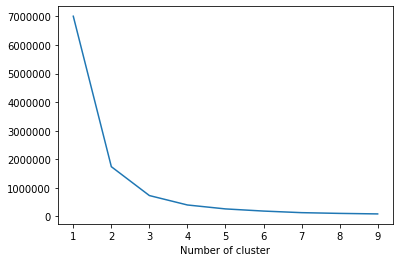

In [26]:
sse={}
tx_recency = tx_user[['Recency']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [27]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [28]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [29]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,14620.0,999.0,104,1
1,14740.0,999.0,91,1
2,16462.0,111.0,85,1
3,15676.0,178.0,113,1
4,15092.0,999.0,115,1


In [30]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,443.0,155.054176,15.613017,127.0,141.0,154.0,167.0,183.0
1,579.0,97.424870,14.208621,75.0,85.0,98.0,110.0,126.0
2,665.0,50.935338,12.413812,33.0,40.0,49.0,62.0,73.0
3,881.0,14.049943,8.883066,0.0,7.0,13.0,21.0,31.0


# Frequency

In [31]:
tx_frequency = tx_6m.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']
tx_frequency.head()

,CustomerID,Frequency
0,12747.0,50
1,12748.0,1210
2,12749.0,160
3,12821.0,6
4,12823.0,2


In [32]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,14620.0,999.0,104,1,30
1,14740.0,999.0,91,1,93
2,16462.0,111.0,85,1,2
3,15676.0,178.0,113,1,63
4,15092.0,999.0,115,1,26


In [33]:
tx_user.Frequency.describe()

count    2568.000000
mean       55.985981
std       109.245890
min         1.000000
25%        13.000000
50%        29.000000
75%        64.000000
max      3546.000000
Name: Frequency, dtype: float64

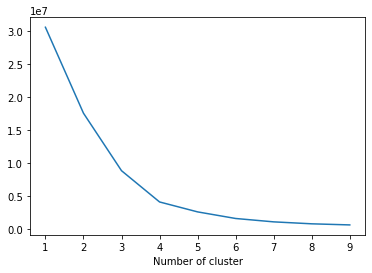

In [34]:
sse={}
tx_frequency = tx_user[['Frequency']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [35]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,14620.0,999.0,104,1,30,0
1,14740.0,999.0,91,1,93,0
2,16462.0,111.0,85,1,2,0
3,15676.0,178.0,113,1,63,0
4,15092.0,999.0,115,1,26,0


In [36]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2239.0,31.732023,26.036899,1.0,11.00,23.0,46.00,107.0
1,16.0,766.062500,260.797103,510.0,555.75,646.5,936.50,1251.0
2,312.0,182.439103,70.488211,108.0,130.00,160.0,212.25,450.0
3,1.0,3546.000000,NaN,3546.0,3546.00,3546.0,3546.00,3546.0


In [37]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,14620.0,999.0,104,1,30,0
1,14740.0,999.0,91,1,93,0
2,16462.0,111.0,85,1,2,0
3,15676.0,178.0,113,1,63,0
4,15092.0,999.0,115,1,26,0


# Monetary Value

In [38]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']

tx_revenue = tx_6m.groupby('CustomerID').Revenue.sum().reset_index()

tx_revenue.head()

,CustomerID,Revenue
0,12747.0,1760.09
1,12748.0,8115.68
2,12749.0,2532.55
3,12821.0,92.72
4,12823.0,688.50


In [39]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

tx_user.Revenue.describe()

count     2568.000000
mean      1078.621843
std       3156.461431
min      -4287.630000
25%        222.967500
50%        440.130000
75%       1026.340000
max      88948.330000
Name: Revenue, dtype: float64

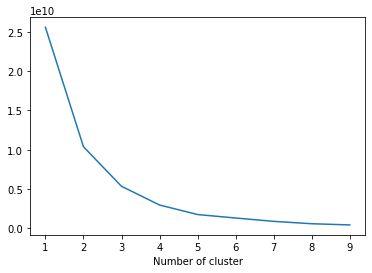

In [40]:
sse={}
tx_revenue = tx_user[['Revenue']].copy()
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [41]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [42]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2415.0,635.360862,618.311128,-4287.63,212.1850,406.480,866.6600,2906.31
1,136.0,5237.716699,2617.500448,2952.40,3282.0950,4419.950,5634.9350,13760.87
2,15.0,24656.247333,7716.951663,15847.56,17484.2400,23196.350,31386.6450,37934.22
3,2.0,76665.615000,17370.382136,64382.90,70524.2575,76665.615,82806.9725,88948.33


# Overall Segmentation

In [43]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,999.0,104,1,30,0,393.28,0
1,14740.0,999.0,91,1,93,0,1423.21,0
2,16462.0,111.0,85,1,2,0,68.00,0
3,15676.0,178.0,113,1,63,0,877.40,0
4,15092.0,999.0,115,1,26,0,457.81,0


In [44]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,155.143836,19.392694,285.837511
1,98.265597,27.224599,446.093084
2,52.656766,37.529703,576.943186
3,18.450808,52.588840,904.059517
4,15.445652,160.429348,2526.410000
5,9.815789,214.855263,6653.958947
6,8.812500,568.562500,13181.453125
7,12.200000,591.600000,46209.390000
8,3.000000,3546.000000,16643.220000


In [45]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    438
1    561
2    606
3    681
4    184
5     76
6     16
7      5
8      1
Name: Recency, dtype: int64

In [46]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,999.0,104,1,30,0,393.28,0,1,Low-Value
1,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value
2,16462.0,111.0,85,1,2,0,68.00,0,1,Low-Value
3,15676.0,178.0,113,1,63,0,877.40,0,1,Low-Value
4,15092.0,999.0,115,1,26,0,457.81,0,1,Low-Value


# Adding new features

In [47]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,15.90
1,545220,48194,DOORMAT HEARTS,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,15.90
2,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-03-01 08:30:00,1.65,14620.0,United Kingdom,19.80
3,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-03-01 08:30:00,4.95,14620.0,United Kingdom,14.85
4,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2011-03-01 08:30:00,3.75,14620.0,United Kingdom,15.00


We create a dataframe with Customer ID and Invoice Day (not datetime). Then we will remove the duplicates since customers can do multiple purchases in a day and difference will become 0 for those.



In [48]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['CustomerID','InvoiceDate']]

#Convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['InvoiceDate'].dt.date

tx_day_order = tx_day_order.sort_values(['CustomerID','InvoiceDate'])

#Drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

Next we create new columns with the dates of last 3 purchases

In [49]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

tx_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05


### Compute the difference of orders between the days for each invoice date:

In [52]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days

tx_day_order.head(10)

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN,65.0,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN,20.0,85.0,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01,34.0,54.0,119.0
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
7326,12748.0,2011-03-08 12:30:00,2011-03-08,NaN,NaN,NaN,NaN,NaN,NaN
10606,12748.0,2011-03-11 11:37:00,2011-03-11,2011-03-08,NaN,NaN,3.0,NaN,NaN
17545,12748.0,2011-03-18 13:08:00,2011-03-18,2011-03-11,2011-03-08,NaN,7.0,10.0,NaN
20123,12748.0,2011-03-21 15:40:00,2011-03-21,2011-03-18,2011-03-11,2011-03-08,3.0,10.0,13.0
24764,12748.0,2011-03-24 13:37:00,2011-03-24,2011-03-21,2011-03-18,2011-03-11,3.0,6.0,13.0


For each customer ID, find out the mean and standard deviation of the difference between purchases in days:

In [53]:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
tx_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']
tx_day_diff.head()

,CustomerID,DayDiffMean,DayDiffStd
0,12747.0,43.500000,20.305993
1,12748.0,3.723404,3.083632
2,12749.0,25.000000,30.099834
3,12821.0,NaN,NaN
4,12823.0,127.000000,NaN


Many customers made multiple purchases whereas other customers made a few transaction. Can we tag a customer as frequent if they made with 1-2 purchases. 

**We only keep customers who have > 3 purchases** by using the following line:


In [54]:
tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'],keep='last')
tx_day_order_last.head(10)

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
192527,12748.0,2011-08-30 12:00:00,2011-08-30,2011-08-25,2011-08-24,2011-08-17,5.0,6.0,13.0
181411,12749.0,2011-08-18 06:19:00,2011-08-18,2011-08-11,2011-08-01,2011-05-23,7.0,17.0,87.0
70339,12821.0,2011-05-09 15:51:00,2011-05-09,NaN,NaN,NaN,NaN,NaN,NaN
169417,12823.0,2011-08-04 17:45:00,2011-08-04,2011-03-30,NaN,NaN,127.0,NaN,NaN
122212,12826.0,2011-06-24 11:47:00,2011-06-24,2011-06-14,NaN,NaN,10.0,NaN,NaN
182629,12828.0,2011-08-19 09:23:00,2011-08-19,2011-08-01,NaN,NaN,18.0,NaN,NaN
162086,12830.0,2011-07-28 17:17:00,2011-07-28,2011-07-21,2011-07-06,2011-06-21,7.0,22.0,37.0
21424,12831.0,2011-03-22 13:02:00,2011-03-22,NaN,NaN,NaN,NaN,NaN,NaN
147556,12833.0,2011-07-17 13:46:00,2011-07-17,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
tx_day_order_last = tx_day_order_last.dropna()
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='CustomerID')


In [56]:
tx_day_order_last.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0,43.500000,20.305993
1,12748.0,2011-08-30 12:00:00,2011-08-30,2011-08-25,2011-08-24,2011-08-17,5.0,6.0,13.0,3.723404,3.083632
2,12749.0,2011-08-18 06:19:00,2011-08-18,2011-08-11,2011-08-01,2011-05-23,7.0,17.0,87.0,25.000000,30.099834
3,12830.0,2011-07-28 17:17:00,2011-07-28,2011-07-21,2011-07-06,2011-06-21,7.0,22.0,37.0,12.333333,4.618802
4,12839.0,2011-08-18 10:01:00,2011-08-18,2011-07-29,2011-07-05,2011-06-09,20.0,44.0,70.0,32.800000,26.166773


In [57]:
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value,6.0,34.0,92.0,30.666667,26.102363
1,17770.0,999.0,98,1,38,0,1143.27,0,1,Low-Value,14.0,77.0,84.0,28.000000,30.512293
2,15643.0,999.0,79,1,36,0,647.40,0,1,Low-Value,5.0,6.0,12.0,25.750000,43.553607
3,14231.0,999.0,79,1,35,0,513.11,0,1,Low-Value,4.0,53.0,103.0,34.333333,26.274195
4,18218.0,999.0,106,1,24,0,626.38,0,1,Low-Value,5.0,61.0,75.0,25.000000,27.221315


In [86]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,14740.0,999.0,91,1,93,0,1423.21,0,1,Low-Value,6.0,34.0,92.0,30.666667,26.102363
1,17770.0,999.0,98,1,38,0,1143.27,0,1,Low-Value,14.0,77.0,84.0,28.000000,30.512293
2,15643.0,999.0,79,1,36,0,647.40,0,1,Low-Value,5.0,6.0,12.0,25.750000,43.553607
3,14231.0,999.0,79,1,35,0,513.11,0,1,Low-Value,4.0,53.0,103.0,34.333333,26.274195
4,18218.0,999.0,106,1,24,0,626.38,0,1,Low-Value,5.0,61.0,75.0,25.000000,27.221315


In [58]:
len(tx_user)

623

Next step is to determine the class for label.

### How to define the label

In [59]:
tx_class = tx_user.copy()
tx_class = pd.get_dummies(tx_class)
tx_class.tail(10)

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
613,16029.0,12.0,7,3,127,1,17081.82,2,6,6.0,7.0,19.0,7.318182,5.276961,1,0,0
614,17511.0,21.0,14,3,450,1,37661.72,2,6,9.0,13.0,28.0,9.625000,7.940403,1,0,0
615,14680.0,26.0,21,3,145,1,15847.56,2,6,14.0,33.0,57.0,19.142857,10.976165,1,0,0
616,14088.0,74.0,28,3,203,1,17886.66,2,6,7.0,15.0,21.0,12.400000,7.436397,1,0,0
617,15311.0,13.0,12,3,1061,2,31277.65,2,7,1.0,4.0,9.0,4.750000,3.417392,1,0,0
618,13089.0,0.0,0,3,895,2,22670.13,2,7,6.0,9.0,12.0,4.214286,3.008409,1,0,0
619,14298.0,23.0,23,3,750,2,23767.94,2,7,18.0,42.0,67.0,14.400000,10.297788,1,0,0
620,17841.0,3.0,3,3,3546,3,16643.22,2,8,3.0,5.0,9.0,3.423077,1.318736,1,0,0
621,18102.0,27.0,26,3,136,1,88948.33,3,7,8.0,16.0,32.0,12.916667,9.718383,1,0,0
622,17450.0,1.0,0,3,116,1,64382.90,3,7,8.0,14.0,34.0,11.666667,8.820971,1,0,0


**One way is to look at statistic summary**

In [60]:
tx_user.NextPurchaseDay.describe()

count    623.000000
mean     176.390048
std      326.482713
min        0.000000
25%       24.500000
50%       47.000000
75%       87.000000
max      999.000000
Name: NextPurchaseDay, dtype: float64

**Deciding the boundaries** is a question for both statistics and business needs. It should make sense in terms of the first one and be easy to take action and communicate. Considering these two, we will have three classes:   

•	0–20: Customers that will purchase in 0–20 days — Class name: 2   
•	21–49: Customers that will purchase in 21–49 days — Class name: 1   
•	≥ 50: Customers that will purchase in more than 50 days — Class name: 0   


In [62]:
tx_class['NextPurchaseDayRange'] = 2
tx_class.loc[tx_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
tx_class.loc[tx_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0


In [63]:
tx_class.NextPurchaseDayRange.value_counts()/len(tx_user)

0    0.475120
1    0.325843
2    0.199037
Name: NextPurchaseDayRange, dtype: float64

In [65]:
 tx_class.query('Frequency > 0')

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
0,14740.0,999.0,91,1,93,0,1423.21,0,1,6.0,34.0,92.0,30.666667,26.102363,0,1,0,0
1,17770.0,999.0,98,1,38,0,1143.27,0,1,14.0,77.0,84.0,28.000000,30.512293,0,1,0,0
2,15643.0,999.0,79,1,36,0,647.40,0,1,5.0,6.0,12.0,25.750000,43.553607,0,1,0,0
3,14231.0,999.0,79,1,35,0,513.11,0,1,4.0,53.0,103.0,34.333333,26.274195,0,1,0,0
4,18218.0,999.0,106,1,24,0,626.38,0,1,5.0,61.0,75.0,25.000000,27.221315,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,13089.0,0.0,0,3,895,2,22670.13,2,7,6.0,9.0,12.0,4.214286,3.008409,1,0,0,2
619,14298.0,23.0,23,3,750,2,23767.94,2,7,18.0,42.0,67.0,14.400000,10.297788,1,0,0,1
620,17841.0,3.0,3,3,3546,3,16643.22,2,8,3.0,5.0,9.0,3.423077,1.318736,1,0,0,2
621,18102.0,27.0,26,3,136,1,88948.33,3,7,8.0,16.0,32.0,12.916667,9.718383,1,0,0,1


In [138]:
#tx_class = tx_class[tx_class.Frequency>10]

see the correlation between our features and label. The correlation matrix is one of the cleanest ways to show this:

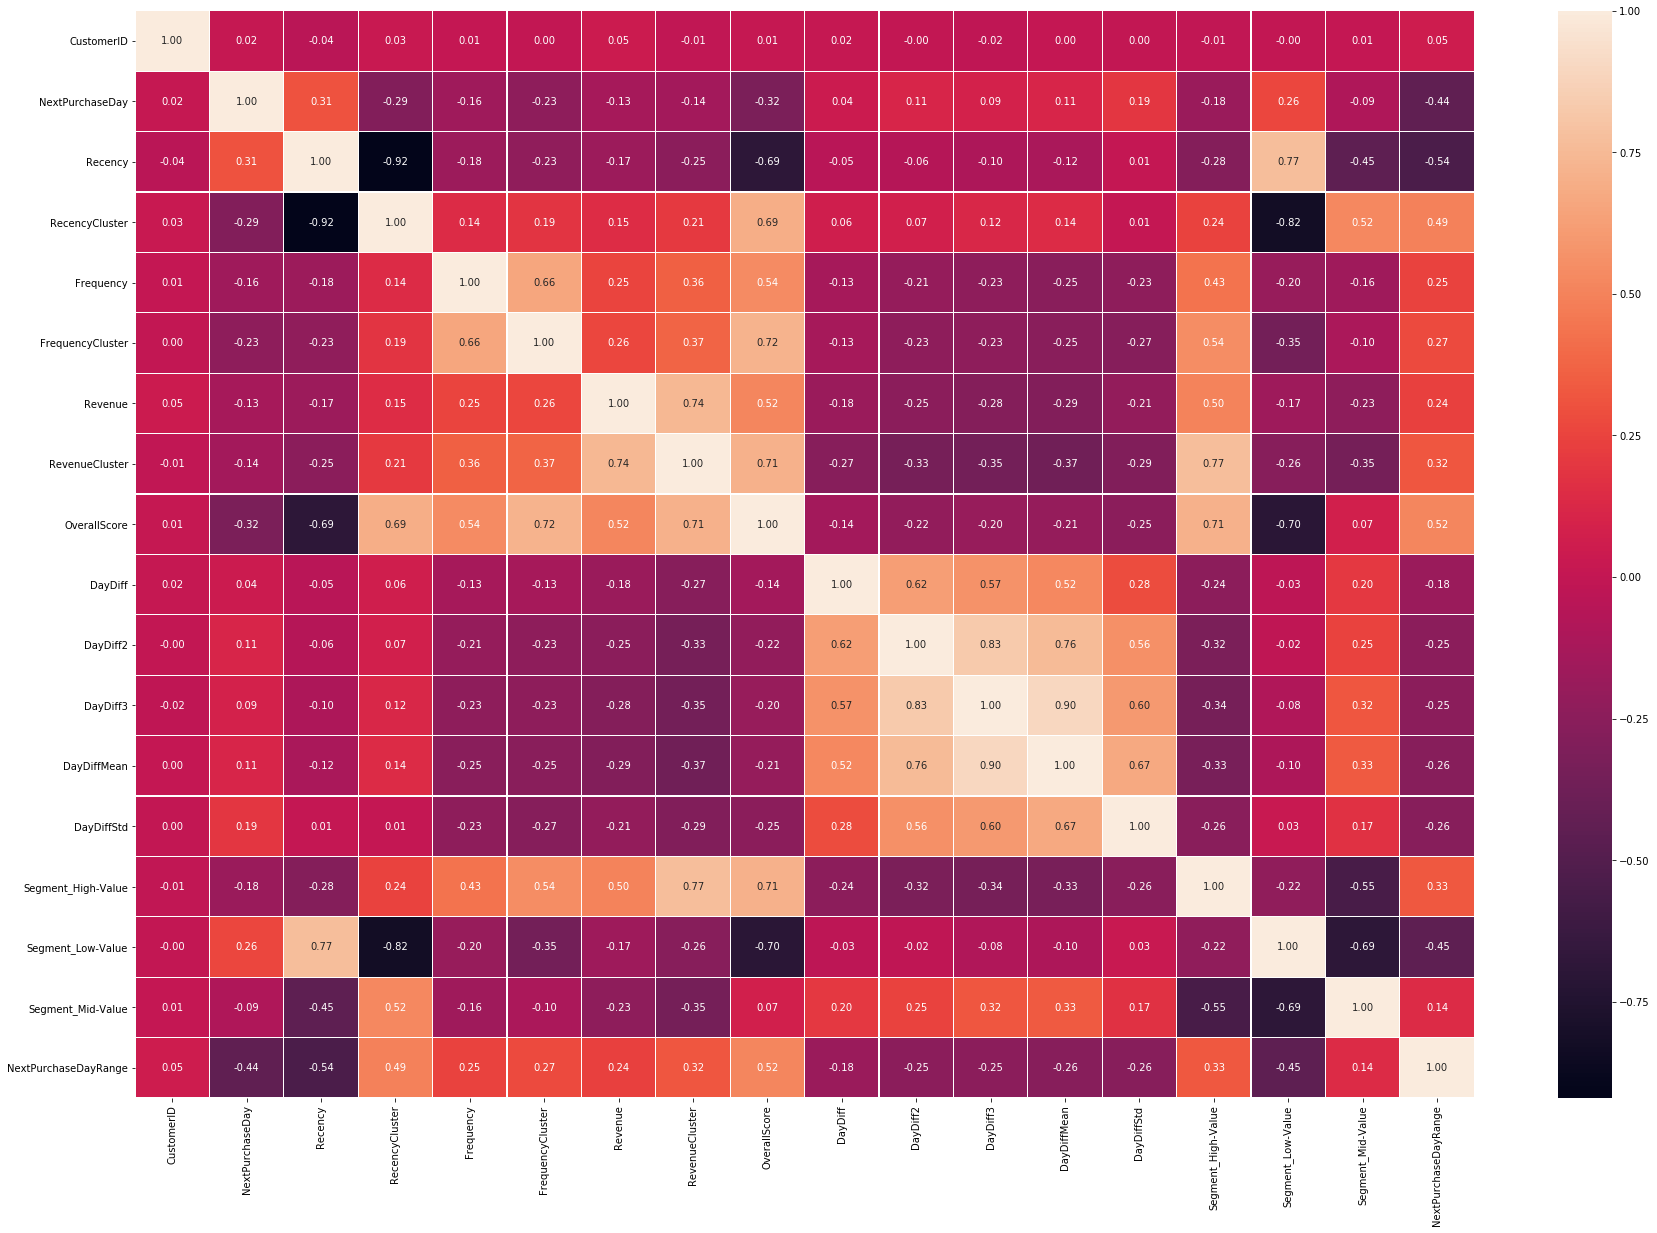

In [66]:
corr = tx_class[tx_class.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [67]:
tx_class = tx_class.drop('NextPurchaseDay',axis=1)
len(tx_class)

623

**Prepare train/test data**

In [68]:
tx_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
0,14740.0,91,1,93,0,1423.21,0,1,6.0,34.0,92.0,30.666667,26.102363,0,1,0,0
1,17770.0,98,1,38,0,1143.27,0,1,14.0,77.0,84.0,28.000000,30.512293,0,1,0,0
2,15643.0,79,1,36,0,647.40,0,1,5.0,6.0,12.0,25.750000,43.553607,0,1,0,0
3,14231.0,79,1,35,0,513.11,0,1,4.0,53.0,103.0,34.333333,26.274195,0,1,0,0
4,18218.0,106,1,24,0,626.38,0,1,5.0,61.0,75.0,25.000000,27.221315,0,1,0,0


In [69]:
X, y = tx_class.drop('NextPurchaseDayRange',axis=1), tx_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [70]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))


In [71]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.61445783 0.60240964]
NB [0.64257028 0.64658635]
RF [0.6064257  0.61445783]
SVC [0.50200803 0.4939759 ]
Dtree [0.51405622 0.56626506]
XGB [0.57429719 0.58232932]
KNN [0.4939759  0.48995984]


In [72]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))



Accuracy of XGB classifier on training set: 0.93
Accuracy of XGB classifier on test set: 0.58


In [74]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.73      0.68        55
           1       0.57      0.42      0.48        50
           2       0.48      0.60      0.53        20

    accuracy                           0.58       125
   macro avg       0.56      0.58      0.56       125
weighted avg       0.58      0.58      0.58       125



In [75]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 5}, 0.6044176706827309)

In [76]:
xgb_model = xgb.XGBClassifier(max_depth=3, min_child_weight=5).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))



Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.62


In [78]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68        55
           1       0.64      0.54      0.59        50
           2       0.50      0.60      0.55        20

    accuracy                           0.62       125
   macro avg       0.60      0.62      0.61       125
weighted avg       0.63      0.62      0.62       125

